In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
import psycopg2


def connect_to_postgres(host, port, database, user, password):
    try:
        # Connect to the PostgreSQL database
        connection = psycopg2.connect(
            host=host, port=port, database=database, user=user, password=password
        )
        print("Connected to PostgreSQL database successfully!")
        return connection
    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
        return None


# Provide your PostgreSQL connection details
host = "localhost"
port = "5432"
database = "postgres"
user = "postgres"
password = "Root@123"

# Connect to the PostgreSQL database
connection = connect_to_postgres(host, port, database, user, password)

# Check if connection is successful before proceeding further
if connection:
    # Add your code here to perform tasks on the database
    pass

Connected to PostgreSQL database successfully!


In [3]:
def fetch_data(connection, query):
    try:
        # Create a cursor object using the connection
        cursor = connection.cursor()

        # Execute the query
        cursor.execute(query)

        # Fetch all the rows
        data = cursor.fetchall()

        # Get the column names
        columns = [desc[0] for desc in cursor.description]

        # Create a DataFrame using the fetched data and column names
        df = pd.DataFrame(data, columns=columns)

        # Close the cursor
        cursor.close()

        return df
    except (Exception, psycopg2.Error) as error:
        print("Error fetching data from PostgreSQL:", error)
        return None


# Define the SQL query to retrieve relevant columns from the xdr_data table
query = """
    SELECT *
    FROM public.xdr_data
"""

# Fetch the data from the database
xdr_data = fetch_data(connection, query)

# Display the first few rows of the fetched data
print(xdr_data.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [4]:
# Step 1: Aggregate engagement metrics per customer ID and report the top 10 customers per metric

# Aggregate session frequency per customer
session_freq_per_customer = (
    xdr_data.groupby("MSISDN/Number")["Bearer Id"].count().reset_index()
)
session_freq_per_customer.columns = ["MSISDN/Number", "Session Frequency"]

# Aggregate session duration per customer
session_duration_per_customer = (
    xdr_data.groupby("MSISDN/Number")["Dur. (ms)"].sum().reset_index()
)
session_duration_per_customer["Session Duration (min)"] = session_duration_per_customer[
    "Dur. (ms)"
] / (
    1000 * 60
)  # Convert milliseconds to minutes
session_duration_per_customer.drop(columns=["Dur. (ms)"], inplace=True)

# Aggregate session total traffic per customer
session_traffic_per_customer = (
    xdr_data.groupby("MSISDN/Number")[["Total UL (Bytes)", "Total DL (Bytes)"]]
    .sum()
    .reset_index()
)
session_traffic_per_customer["Total Session Traffic (Bytes)"] = (
    session_traffic_per_customer["Total UL (Bytes)"]
    + session_traffic_per_customer["Total DL (Bytes)"]
)
session_traffic_per_customer.drop(
    columns=["Total UL (Bytes)", "Total DL (Bytes)"], inplace=True
)

# Report the top 10 customers for each engagement metric
top_10_session_freq = session_freq_per_customer.sort_values(
    by="Session Frequency", ascending=False
).head(10)
top_10_session_duration = session_duration_per_customer.sort_values(
    by="Session Duration (min)", ascending=False
).head(10)
top_10_session_traffic = session_traffic_per_customer.sort_values(
    by="Total Session Traffic (Bytes)", ascending=False
).head(10)

# Display the top 10 customers for each engagement metric
print("Top 10 Customers by Session Frequency:")
print(top_10_session_freq)
print("\nTop 10 Customers by Session Duration:")
print(top_10_session_duration)
print("\nTop 10 Customers by Session Traffic:")
print(top_10_session_traffic)

Top 10 Customers by Session Frequency:
       MSISDN/Number  Session Frequency
13526   3.362632e+10                 18
13180   3.362578e+10                 17
6437    3.361489e+10                 17
37052   3.365973e+10                 16
76363   3.367588e+10                 15
92923   3.376054e+10                 15
65118   3.366716e+10                 13
92577   3.376041e+10                 12
1279    3.360452e+10                 12
666     3.360313e+10                 12

Top 10 Customers by Session Duration:
       MSISDN/Number  Session Duration (min)
13180   3.362578e+10              309.229233
6437    3.361489e+10              166.114967
92923   3.376054e+10              154.657233
13526   3.362632e+10              146.532117
65118   3.366716e+10              145.748567
50281   3.366284e+10              110.237833
57160   3.366469e+10              104.812167
666     3.360313e+10              104.796017
66029   3.366746e+10               94.164700
92577   3.376041e+10            

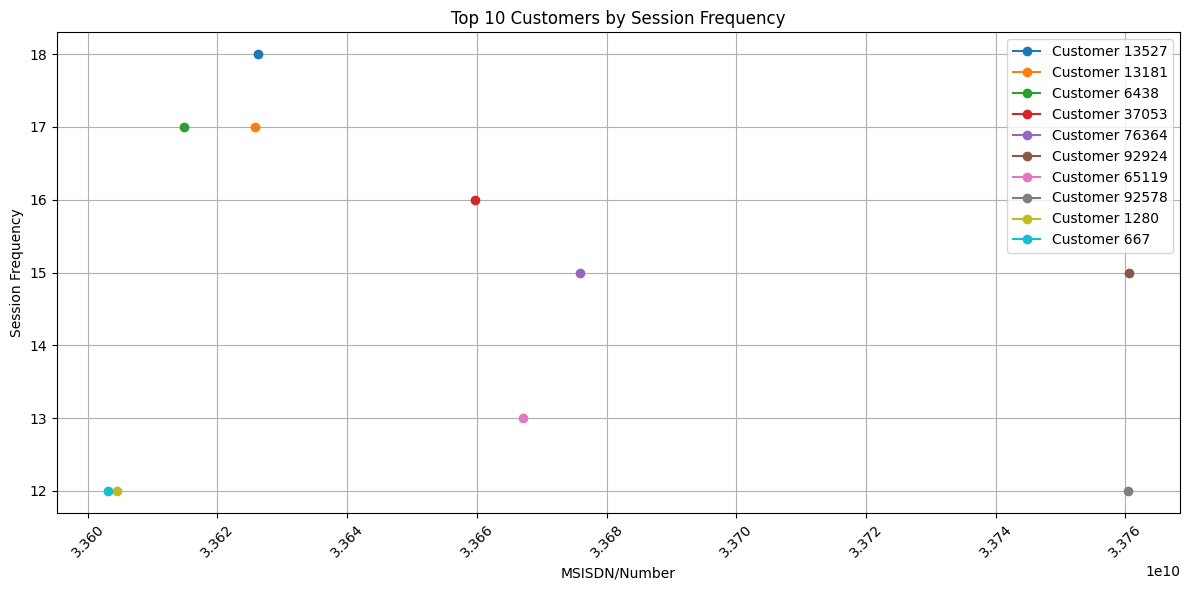

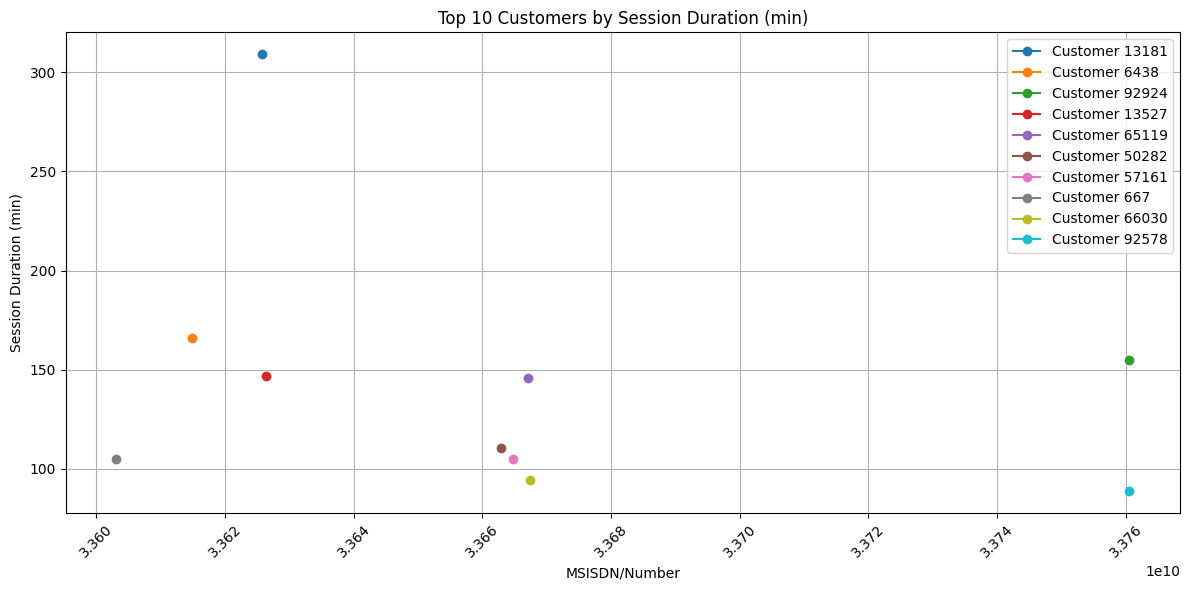

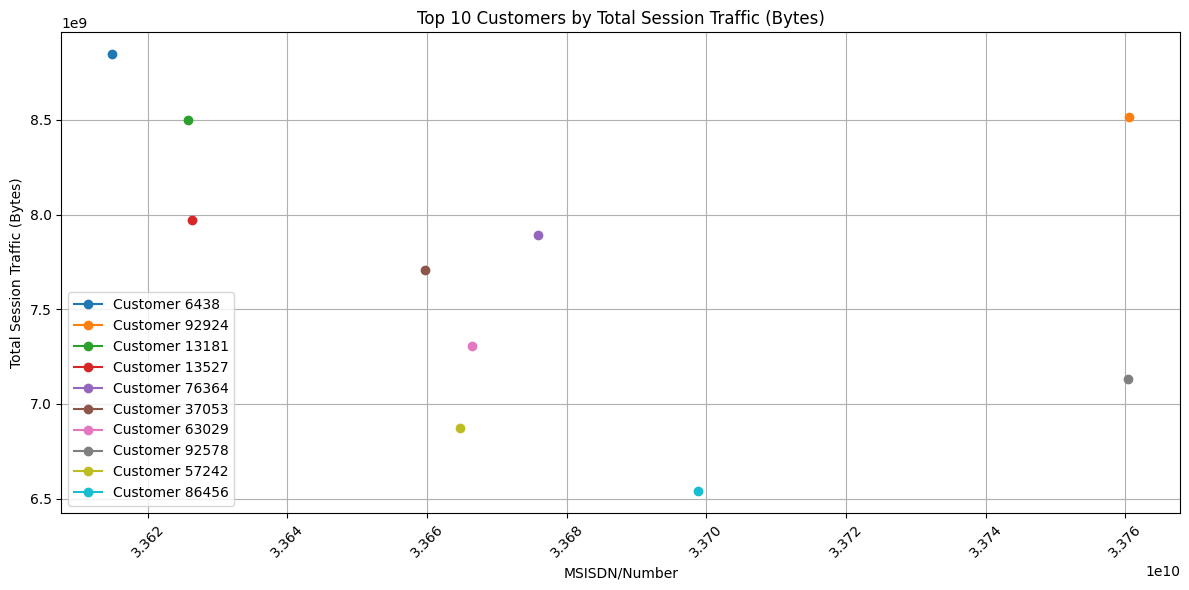

In [20]:
import matplotlib.pyplot as plt


# Function to plot top 10 customers for an engagement metric
def plot_top_10_customers(data, metric_name, ylabel):
    plt.figure(figsize=(12, 6))
    for i, row in data.iterrows():
        plt.plot(
            row["MSISDN/Number"], row[metric_name], marker="o", label=f"Customer {i+1}"
        )

    plt.xlabel("MSISDN/Number")
    plt.ylabel(ylabel)
    plt.title(f"Top 10 Customers by {metric_name}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting top 10 customers by session frequency
plot_top_10_customers(top_10_session_freq, "Session Frequency", "Session Frequency")

# Plotting top 10 customers by session duration
plot_top_10_customers(
    top_10_session_duration, "Session Duration (min)", "Session Duration (min)"
)

# Plotting top 10 customers by session traffic
plot_top_10_customers(
    top_10_session_traffic,
    "Total Session Traffic (Bytes)",
    "Total Session Traffic (Bytes)",
)

Count of customers in each cluster:
Cluster
0    49775
1    47588
2     9493
Name: count, dtype: int64


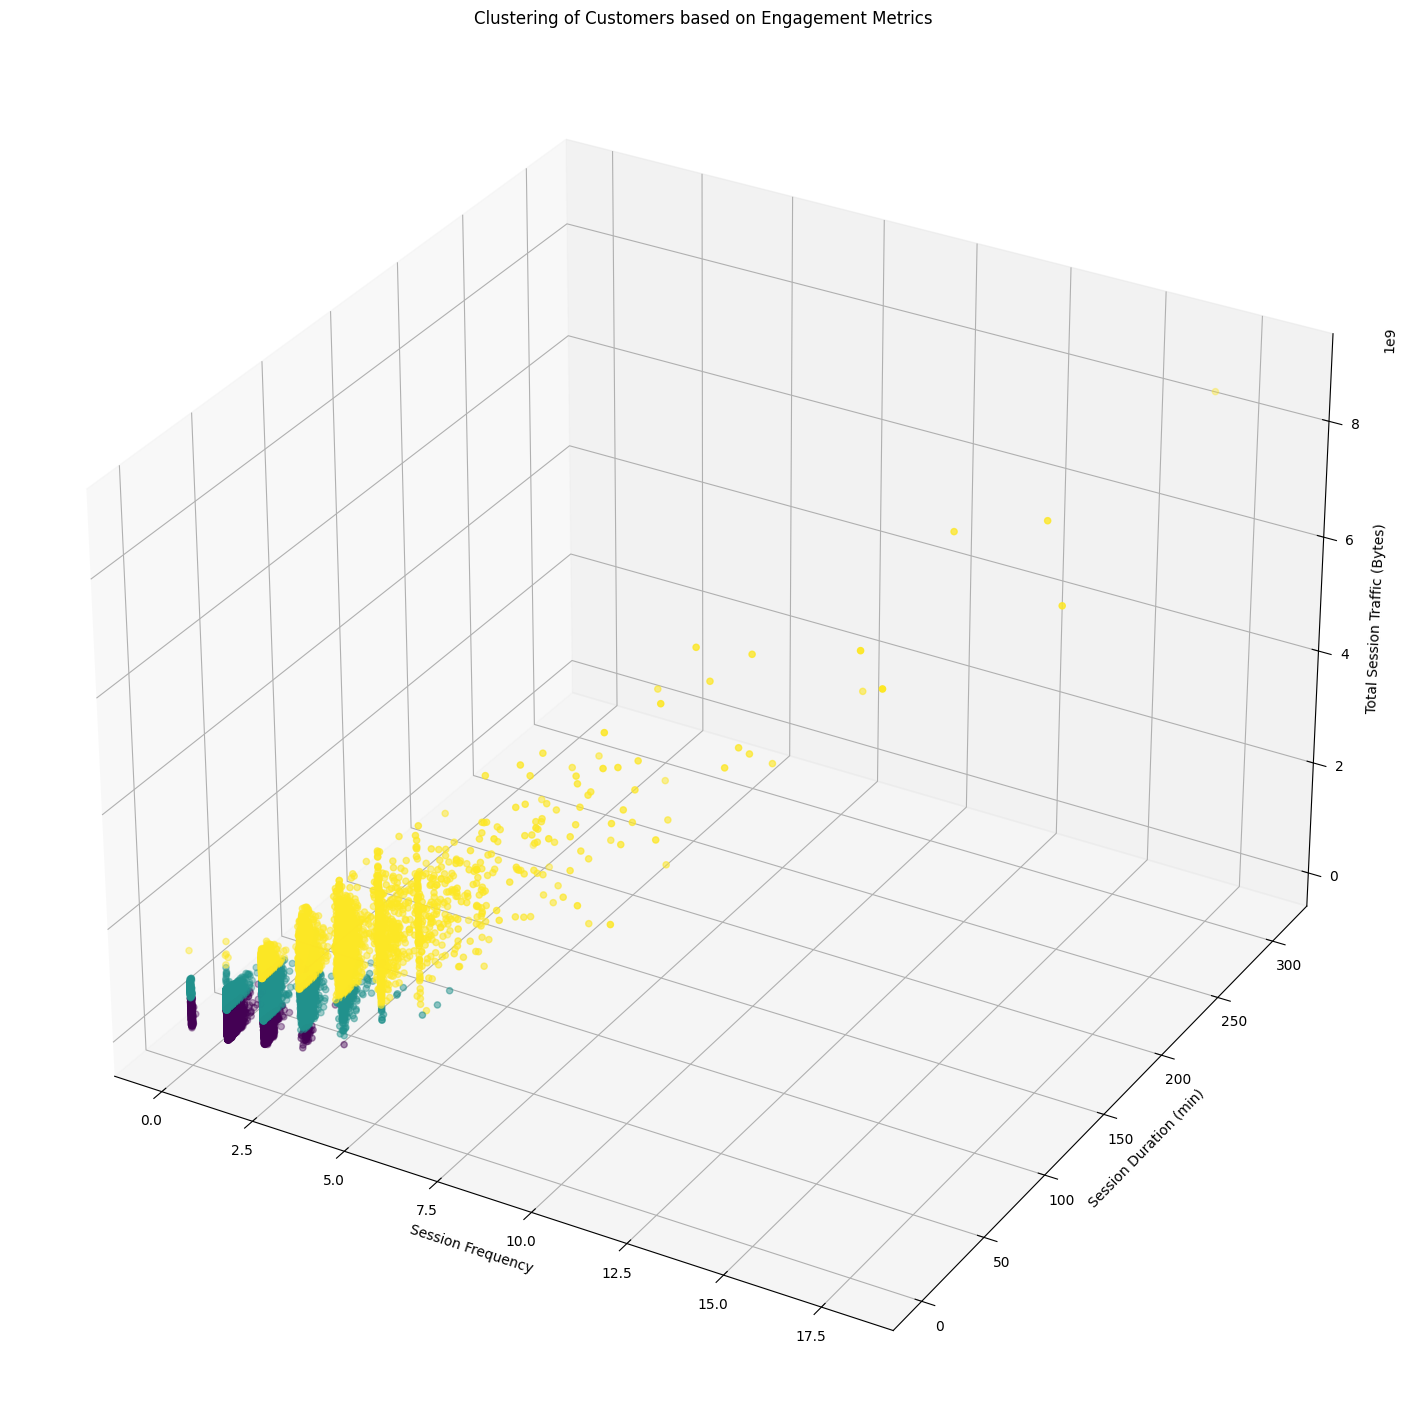

In [5]:
# Step 2: Modify k-means clustering using engagement metrics

import matplotlib.pyplot as plt

# Select engagement metrics for clustering
engagement_metrics = pd.concat(
    [
        session_freq_per_customer["Session Frequency"],
        session_duration_per_customer["Session Duration (min)"],
        session_traffic_per_customer["Total Session Traffic (Bytes)"],
    ],
    axis=1,
)

# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(engagement_metrics)

# Add cluster labels to the DataFrame
session_freq_per_customer["Cluster"] = kmeans.labels_

# Display the count of customers in each cluster
print("Count of customers in each cluster:")
print(session_freq_per_customer["Cluster"].value_counts())

# Plot clusters in 3D space
fig = plt.figure(figsize=(19, 18))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    session_freq_per_customer["Session Frequency"],
    session_duration_per_customer["Session Duration (min)"],
    session_traffic_per_customer["Total Session Traffic (Bytes)"],
    c=session_freq_per_customer["Cluster"],
    cmap="viridis",
)
ax.set_xlabel("Session Frequency")
ax.set_ylabel("Session Duration (min)")
ax.set_zlabel("Total Session Traffic (Bytes)")
ax.set_title("Clustering of Customers based on Engagement Metrics")

plt.show()

In [6]:
# Step 3: Aggregate user total traffic per application and derive the top 10 most engaged users per application

# Select relevant columns for application traffic
application_traffic_columns = [
    "Social Media DL (Bytes)",
    "Social Media UL (Bytes)",
    "Google DL (Bytes)",
    "Google UL (Bytes)",
    "Email DL (Bytes)",
    "Email UL (Bytes)",
    "Youtube DL (Bytes)",
    "Youtube UL (Bytes)",
    "Netflix DL (Bytes)",
    "Netflix UL (Bytes)",
    "Gaming DL (Bytes)",
    "Gaming UL (Bytes)",
    "Other DL (Bytes)",
    "Other UL (Bytes)",
]

# Aggregate total traffic per application for each user
user_application_traffic = xdr_data.groupby("MSISDN/Number")[
    application_traffic_columns
].sum()

# Summarize total traffic across all applications for each user
user_application_traffic["Total Traffic (Bytes)"] = user_application_traffic.sum(axis=1)

# Identify the top 10 most engaged users per application
top_10_users_per_application = {}
for column in application_traffic_columns:
    top_users = user_application_traffic.sort_values(by=column, ascending=False).head(
        10
    )
    top_10_users_per_application[column] = top_users

# Display the top 10 most engaged users per application
for app, top_users in top_10_users_per_application.items():
    print(f"Top 10 Users for {app}:")
    print(top_users)
    print()

Top 10 Users for Social Media DL (Bytes):
               Social Media DL (Bytes)  Social Media UL (Bytes)  \
MSISDN/Number                                                     
3.362632e+10                42743837.0                 630942.0   
3.376054e+10                39297646.0                 485543.0   
3.365973e+10                34900444.0                 511914.0   
3.361489e+10                27749744.0                 544800.0   
3.362578e+10                26564121.0                 571379.0   
3.366716e+10                23753753.0                 494097.0   
3.378632e+10                23568655.0                 406264.0   
3.366907e+10                23477047.0                 323787.0   
3.360313e+10                22776679.0                 301146.0   
3.365849e+10                22695673.0                 304393.0   

               Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                           
3.36263

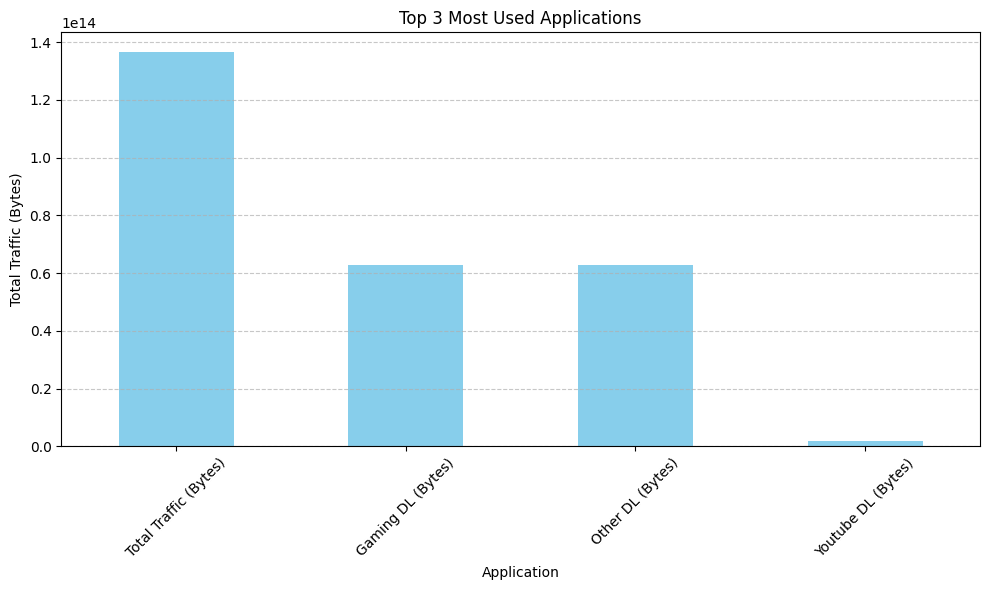

In [16]:
# Step 4: Plot the top 3 most used applications using appropriate charts

# Aggregate total traffic for each application
total_traffic_per_application = user_application_traffic.sum()

# Sort the applications based on total traffic
top_3_applications = total_traffic_per_application.nlargest(4)

# Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
top_3_applications.plot(kind="bar", color="skyblue")
plt.title("Top 3 Most Used Applications")
plt.xlabel("Application")
plt.ylabel("Total Traffic (Bytes)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

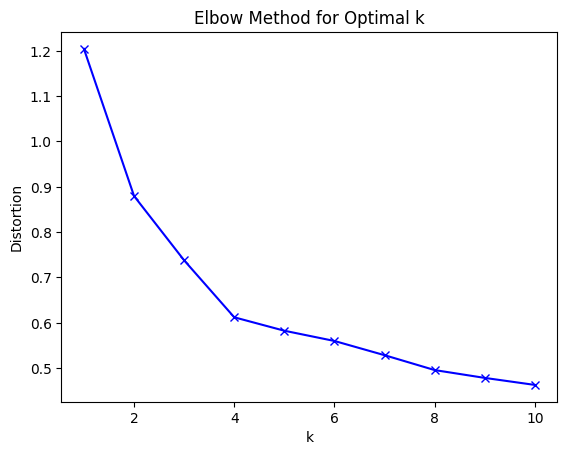

In [8]:

# Select engagement metrics for clustering
engagement_metrics = pd.concat(
    [
        session_freq_per_customer["Session Frequency"],
        session_duration_per_customer["Session Duration (min)"],
        session_traffic_per_customer["Total Session Traffic (Bytes)"],
    ],
    axis=1,
)

# Drop rows with NaN values
engagement_metrics.dropna(inplace=True)

# Standardize engagement metrics
scaler = StandardScaler()
scaled_engagement_metrics = scaler.fit_transform(engagement_metrics)

# Determine the optimal value of k using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(scaled_engagement_metrics)
    distortions.append(
        sum(
            np.min(
                cdist(
                    scaled_engagement_metrics,
                    kmeans_model.cluster_centers_,
                    "euclidean",
                ),
                axis=1,
            )
        )
        / scaled_engagement_metrics.shape[0]
    )

# Plot the elbow curve
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("Elbow Method for Optimal k")
plt.show()

Count of users in each cluster:
Cluster
0    79811
1    23461
2     3584
Name: count, dtype: int64


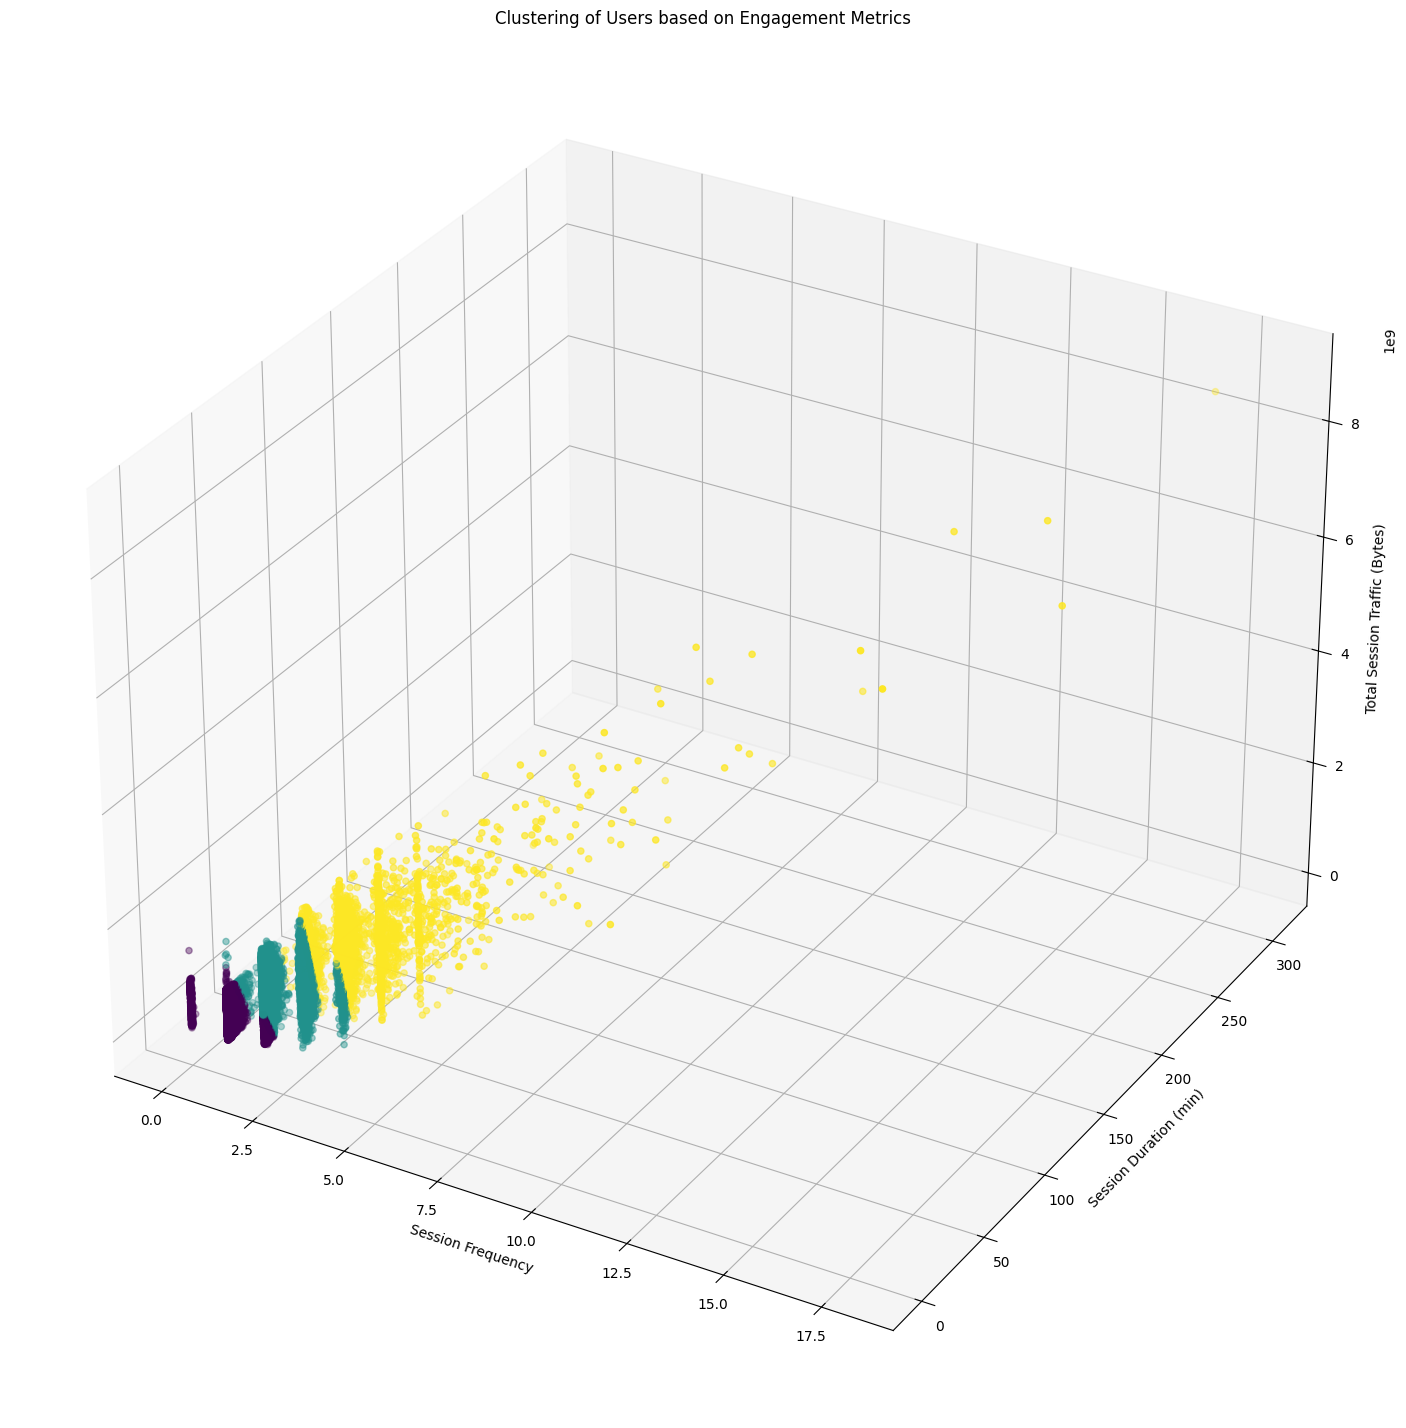

In [9]:
# Run k-means clustering with the optimized value of k
optimal_k = 3
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_model.fit(scaled_engagement_metrics)

# Add cluster labels to the DataFrame
engagement_metrics["Cluster"] = kmeans_model.labels_

# Display the count of users in each cluster
print("Count of users in each cluster:")
print(engagement_metrics["Cluster"].value_counts())

# Plot clusters in 3D space
fig = plt.figure(figsize=(19, 18))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    engagement_metrics["Session Frequency"],
    engagement_metrics["Session Duration (min)"],
    engagement_metrics["Total Session Traffic (Bytes)"],
    c=engagement_metrics["Cluster"],
    cmap="viridis",
)
ax.set_xlabel("Session Frequency")
ax.set_ylabel("Session Duration (min)")
ax.set_zlabel("Total Session Traffic (Bytes)")
ax.set_title("Clustering of Users based on Engagement Metrics")

plt.show()

In [10]:
# Group the data by 'Handset Manufacturer' and 'Handset Type' and count the occurrences
handset_usage = (
    xdr_data.groupby(["Handset Manufacturer", "Handset Type"])
    .size()
    .reset_index(name="Usage Count")
)

# Sort the results to find the top 10 handsets based on usage frequency
top_10_handsets = handset_usage.sort_values(by="Usage Count", ascending=False).head(10)

print("Top 10 Handsets Used by Customers:")
print(top_10_handsets)

Top 10 Handsets Used by Customers:
     Handset Manufacturer                  Handset Type  Usage Count
316                Huawei              Huawei B528S-23A        19752
60                  Apple       Apple iPhone 6S (A1688)         9419
56                  Apple        Apple iPhone 6 (A1586)         9023
1395            undefined                     undefined         8987
66                  Apple        Apple iPhone 7 (A1778)         6326
80                  Apple       Apple iPhone Se (A1723)         5187
73                  Apple        Apple iPhone 8 (A1905)         4993
85                  Apple       Apple iPhone Xr (A2105)         4568
957               Samsung  Samsung Galaxy S8 (Sm-G950F)         4520
82                  Apple        Apple iPhone X (A1901)         3813


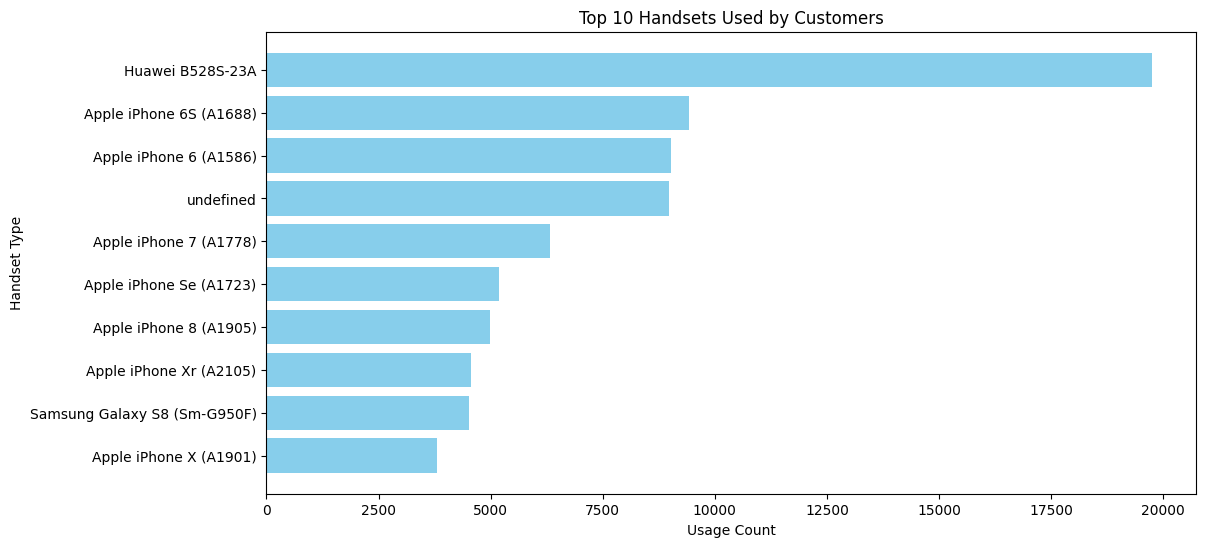

In [11]:
import matplotlib.pyplot as plt

# Plotting the distribution of handset usage
plt.figure(figsize=(12, 6))
plt.barh(
    top_10_handsets["Handset Type"], top_10_handsets["Usage Count"], color="skyblue"
)
plt.xlabel("Usage Count")
plt.ylabel("Handset Type")
plt.title("Top 10 Handsets Used by Customers")
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

In [14]:
# Group the data by 'Handset Manufacturer' and count the occurrences
manufacturer_usage = (
    xdr_data.groupby("Handset Manufacturer").size().reset_index(name="Usage Count")
)

# Sort the results to find the top 3 handset manufacturers based on usage frequency
top_3_manufacturers = manufacturer_usage.sort_values(
    by="Usage Count", ascending=False
).head(3)

print("Top 3 Handset Manufacturers:")
print(top_3_manufacturers)

Top 3 Handset Manufacturers:
    Handset Manufacturer  Usage Count
5                  Apple        59565
103              Samsung        40839
52                Huawei        34423


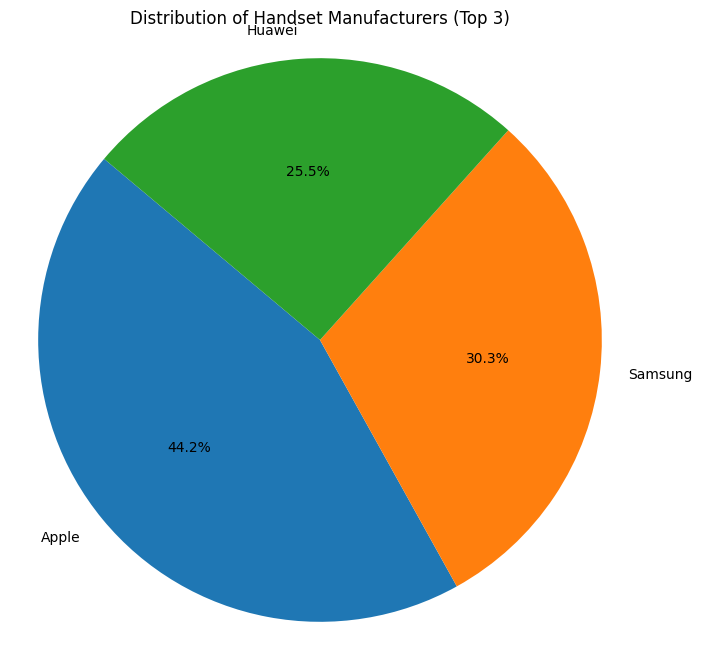

In [15]:
# Plotting the distribution of handset manufacturers using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    top_3_manufacturers["Usage Count"],
    labels=top_3_manufacturers["Handset Manufacturer"],
    autopct="%1.1f%%",
    startangle=140,
)
plt.title("Distribution of Handset Manufacturers (Top 3)")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()